# Convolutional autoencoding and clustering for automatic puzzeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import sys
import os
import tensorflow as tf
from tensorflow import keras

## Load and Preprocess Data

Size of dataset: 100
Size of image: (453, 422, 4)
Type: <class 'numpy.ndarray'>


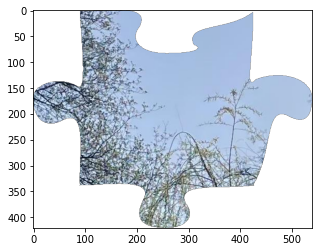

In [2]:
images = [plt.imread(os.path.join('data', 'size-100', 'raster', str(file_num)+'.png')) for file_num in range(100)]

num_images = len(images)
print('Size of dataset: '+ str(num_images))
print('Size of image: '+ str(images[7].shape))
print('Type: '+str(type(images[1])))
plt.imshow(images[79])

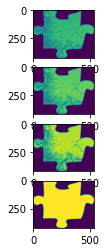

In [3]:
img = images[79]
fig, axs = plt.subplots(4)
for layer in range(0,4):
    axs[layer].imshow(img[:,:,layer])




### Extract shape of the piece and add padding

In [4]:
# Here we get the max length and width for later padding
width_array = [images[i].shape[0] for i in range(num_images)]
length_array = [images[i].shape[1] for i in range(num_images)]
#maxw = np.max(width_array)
#maxl = np.max(length_array)

maxw = 576
maxl = 576
print('max width: '+ str(maxw) + ", max length: " + str(maxl))

# The last layer is the transparency layer, which is basically the shape of the piece
images_bw = [image[:,:,3] for image in images] 

# Here comes the padding
images_p = []
for image in images_bw: 
    # image = images_bw[5]
    w,l = image.shape
    width_ext = int((maxw - w)/2)
    length_ext = int((maxl - l)/2)
    
    #Blocks of zeros to complete the padding
    zero_block_w = np.zeros([width_ext, l]) 
    zero_block_l = np.zeros([maxw,length_ext])

    if w+2*width_ext == maxw: # This is to be sure that all images are going to have the same dimentions
        image_p = np.concatenate((zero_block_w,image,zero_block_w),axis=0) 
    else:
        extraline_w = np.zeros([1,l]) # This extra lines are to complete the dimensions if necessary
        image_p = np.concatenate((zero_block_w,image,zero_block_w,extraline_w),axis=0)

    if l+2*length_ext == maxl:
        image_p = np.concatenate((zero_block_l,image_p,zero_block_l),axis=1)
    else:
        extraline_l = np.zeros([maxw,1])
        image_p = np.concatenate((zero_block_l,image_p,zero_block_l,extraline_l),axis=1)

    # print(image_p.shape)
    # We save the negative of the image on the list
    
    #images_p.append(np.abs(-(image_p-1)))
    images_p.append(image_p)


max width: 576, max length: 576


<class 'numpy.ndarray'>
(576, 576)
1.0
0.0


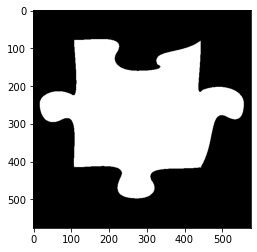

In [6]:
image_bw = images_p[79]
plt.imshow(image_bw,cmap = 'gray')
# plt.imshow(image_bw,cmap = 'Greys')

print(type(image_bw))
print(image_bw.shape)
print(np.max(image_bw))
print(np.min(image_bw))


### Resize Image

In [7]:
# If you want a 64x64 image, size = stride = 9
size = 9
stride = 9
images_rs = []
shape_new_image = (int(image_p.shape[0]/size),int(image_p.shape[0]/size))


for image_p in images_p: 
    image_rs = np.zeros(shape_new_image)
    i_rs = 0
    j_rs = 0
    for i in range(0,image_p.shape[0]-int(size/2),stride):
        for j in range(0,image_p.shape[1]-int(size/2),stride):
            window = image_p[i:i+size,j:j+size].flatten()
            # image_rs[i_rs][j_rs] = np.max(window) # choose how to reduce the size of the image
            image_rs[i_rs][j_rs] = np.mean(window) # choose how to reduce the size of the image
            #image_rs[i_rs][j_rs] = window[0] # choose how to reduce the size of the image
            j_rs += 1
        i_rs += 1
        j_rs = 0
    images_rs.append(image_rs)
    
#plt.imshow(image_rs,cmap = 'Greys')

<class 'numpy.ndarray'>
(64, 64)
1.0
0.0


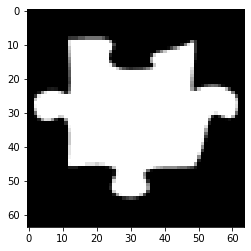

In [8]:
image_rs = images_rs[79]
plt.imshow(image_rs,cmap = 'gray')
print(type(image_rs))
print(image_rs.shape)
print(np.max(image_rs))
print(np.min(image_rs))

## Encode Image Data
### Convolutional Autoencoder

In [9]:
from keras.layers import Conv2D
from keras.layers import Input

from keras.layers import MaxPooling2D, UpSampling2D
from keras.models import Model

from sklearn.model_selection import train_test_split

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [11]:
X = np.array(images_rs)
y = X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:

input_img = Input(shape=(64, 64, 1))

# Encoder
enc_conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
enc_pool1 = MaxPooling2D((2, 2), padding='same')(enc_conv1)
enc_conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(enc_pool1)
enc_pool2 = MaxPooling2D((2, 2), padding='same')(enc_conv2)
enc_conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(enc_pool2)
enc_output = MaxPooling2D((2, 2), padding='same')(enc_conv3)

#decoder
dec_conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(enc_output)
dec_upsample1 = UpSampling2D((2, 2))(dec_conv1)
dec_conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(dec_upsample1)
dec_upsample2 = UpSampling2D((2, 2))(dec_conv2)
dec_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(dec_upsample2)
dec_upsample3 = UpSampling2D((2, 2))(dec_conv3)
dec_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(dec_upsample3)



#dec_conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(enc_ouput)
#dec_upsample1 = UpSampling2D((2, 2))(dec_conv2)
#dec_conv3 = Conv2D(8, (3, 3), activation='relu')(dec_upsample2)
#dec_upsample3 = UpSampling2D((2, 2))(dec_conv3)
#dec_output = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(dec_upsample3)


autoencoder = Model(input_img, dec_output)
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy') 

 

autoencoder.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 8)         584 

In [14]:
# Show some result
autoencoder.fit(X_train, X_train, epochs=100, batch_size=10, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/100
7/7 [==============================] - 2s 71ms/step - loss: 0.6651
Epoch 2/100
7/7 [==============================] - 0s 64ms/step - loss: 0.4871
Epoch 3/100
7/7 [==============================] - 0s 60ms/step - loss: 0.3425
Epoch 4/100
7/7 [==============================] - 0s 61ms/step - loss: 0.2805
Epoch 5/100
7/7 [==============================] - 1s 71ms/step - loss: 0.2552
Epoch 6/100
7/7 [==============================] - 0s 63ms/step - loss: 0.2425
Epoch 7/100
7/7 [==============================] - 0s 62ms/step - loss: 0.2304
Epoch 8/100
7/7 [==============================] - 0s 66ms/step - loss: 0.2250
Epoch 9/100
7/7 [==============================] - 0s 62ms/step - loss: 0.2009
Epoch 10/100
7/7 [==============================] - 0s 53ms/step - loss: 0.2260
Epoch 11/100
7/7 [==============================] - 0s 53ms/step - loss: 0.1921
Epoch 12/100
7/7 [==============================] - 0s 53ms/step - loss: 0.2102
Epoch 13/100
7/7 [==============================]

1/1 [==============================] - 0s 284ms/step


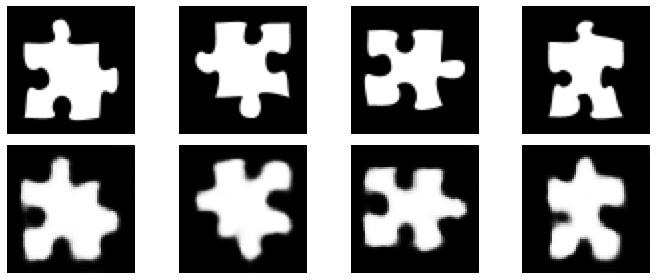

In [15]:
reconstructed_images = autoencoder.predict(X_test) # reconstruct images from X_test

image_shape = (64, 64, 1)

# Display original and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 4))
for i in range(4):
    axes[0, i].imshow(X_test[i], cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

In [25]:
encoder = Model(input_img, enc_output)
encoded_imgs = encoder.predict(X)
encoded_imgs.shape

4/4 [==============================] - 0s 16ms/step


(100, 8, 8, 8)

In [49]:
reconstructed_images = autoencoder.predict(X).reshape(100,64,64) # Check dimensions
mse = tf.keras.losses.MeanSquaredError()
mse_autoencoder = mse(X, reconstructed_images).numpy() 
reconstructibilty = 1 - mse_autoencoder
compression_rate =1 - 8*8*8/(64*64)
print("MSE: " + str(mse_autoencoder))
print("Reconstructibility: " + str(reconstructibilty))
print("Compression rate: " + str(compression_rate))

4/4 [==============================] - 0s 31ms/step
MSE: 0.014226406
Reconstructibility: 0.9857735941186547
Compression rate: 0.875


### Principal Component Analysis

In [50]:
from sklearn.decomposition import PCA

In [68]:
#
X_flat = np.reshape(X,(100,-1))
print(X_flat.shape)
num_components = 50
# Create a PCA object and specify the number of components you want to keep
pca = PCA(n_components=num_components)

# Fit the PCA model to the data
pca.fit(X_flat)

# Transform the data to the lower-dimensional space
X_pca = pca.transform(X_flat)

(100, 4096)


In [69]:
pca2 = PCA(n_components=100)
pca2.fit(X_flat)
X_pca2 = pca2.transform(X_flat)

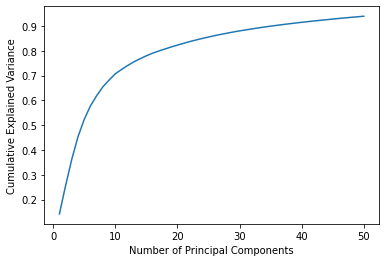

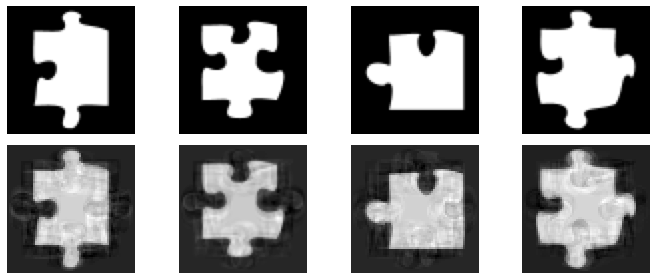

In [57]:
image_shape = (64, 64, 1)

# Variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

# Plot the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Reconstruct a subset of principal components to visualize the reconstructed images
num_reconstructed_components = num_components
reconstructed_images = pca.inverse_transform(X_pca[:, :num_reconstructed_components])

# Reshape the reconstructed images back to their original shape
reconstructed_images = np.reshape(reconstructed_images, (num_images, *image_shape))

# Display original and reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 4))
for i in range(4):
    axes[0, i].imshow(X[i], cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed_images[i], cmap='gray')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

In [72]:
#pca.score_samples(X)
#pca.components_.shape
print(np.sum(pca.singular_values_))
#np.linalg.eigvals(pca)
#pca.components_
print(np.sum(pca2.singular_values_))
reconstructability =np.sum(pca.singular_values_)/np.sum(pca2.singular_values_)
print("Reconstructability: "+str(reconstructability))
print("Compression: "+str(50/100))


1042.3192451437942
1365.3120960657793
Reconstructability: 0.7634292907440676
Compression: 0.5


### Investigate the encoding approaches

48
48


## Clustering
### K-means

In [129]:
# Add code here
def init_centroids(n_clusters,X_data):
    n=X_data.shape[1]
    l = np.min(X_data)
    h = np.max(X_data)
    
    centroids = np.random.uniform(low=l,high=h,size=(n_clusters,n))
    return np.vstack(centroids)

def assign_samples(Centroids,X_data):
    dists = np.vstack([np.linalg.norm(X_data - c, axis = 1) for c in Centroids]).T
    
    labels = np.where(dists == np.repeat(np.min(dists, axis = 1).reshape(-1, 1), Centroids.shape[0], axis = 1))[1]
    
    return labels


def update_centroids(Clusters, X_data):
    labels = assign_samples(Clusters,X_data)
    
    new_Clusters = Clusters
    
    for i in range(Clusters.shape[0]):
        indeces = labels == i
        if indeces.shape[0] > 200:
            pdb.set_trace()
        if np.sum(indeces) >= 1:
            cluster = X_data[indeces,:]
            mean_cluster = np.mean(cluster,axis = 0)
            new_Clusters[i,:] = mean_cluster
    
    return new_Clusters
  

def kmeans(n_clusters, X_data, n_inits, max_iter,eps):
    best_cluster = []
    best_cost = np.inf
    
    
    for i in range(n_inits):
        old_centroids = init_centroids(n_clusters,X_data)
        
        for j in range(max_iter):
            new_centroids = update_centroids(old_centroids, X_data)
            
            if np.sum(np.linalg.norm(new_centroids - old_centroids, axis = 1)) < eps:
                break
            old_centroids = new_centroids
        
        new_cost = compute_cost(new_centroids, X_data)
        
        if new_cost < best_cost:
            best_cluster = new_centroids
            best_cost = new_cost
            
    return best_cluster, best_cost

# Parameters
n_clusters = 10

#
X_flat = 
# Initialize clusters
Centroids = init_centroids(n_clusters, X_)

# Obtain the assignment to the different clusters
Y = assign_samples(Centroids, X_b)

n_inits = 20
max_iter = 100
eps = 1e-6

# Initialize data containers
centroids = []
costs = []

# Cluster for various values of k
for n_clusters in range(1, 9):
    
    # Run kmeans
    centroid_k, cost_k = kmeans(n_clusters, X_b, n_inits, max_iter, eps)
    
    # Update data
    centroids.append(centroid_k)
    costs.append(cost_k)

plt.bar(np.arange(1, len(costs) + 1), np.array(costs), width = 0.5)
ax = plt.gca()
ax.plot(np.arange(1, len(costs) + 1), np.array(costs), lw = 10, c = 'C2')

In [74]:
from sklearn.cluster import KMeans

4/4 [==============================] - 0s 11ms/step
(100, 8, 8, 8)
4/4 [==============================] - 0s 11ms/step
(100, 512)
OMG: :o (100,)
label smg [1 1 4 2 4 4 2 2 1 1 3 2 2 0 2 2 0 0 2 4 1 0 1 0 4 3 4 3 4 4 2 0 0 2 0 2 0
 0 1 3 0 0 3 4 3 4 2 1 3 3 2 2 0 0 2 0 3 4 1 3 2 3 4 2 0 1 0 4 4 4 2 2 0 1
 1 2 1 3 0 0 4 4 0 2 0 0 0 3 4 4 2 3 4 3 4 4 2 4 2 1]


C:\Users\chava\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chava\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


TypeError: 'int' object is not subscriptable

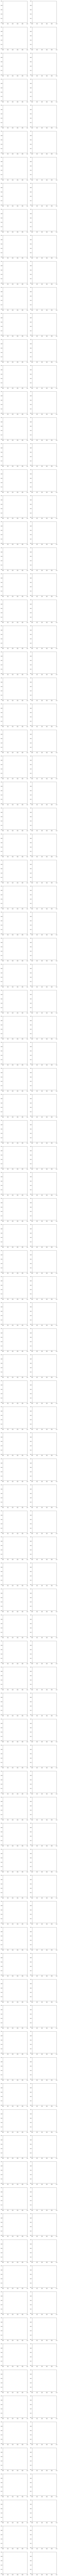

In [92]:
print(encoder.predict(X).shape)
flattened_encoded_images = encoded_imgs = encoder.predict(X).reshape(100,-1)
print(flattened_encoded_images.shape)
n_samples = 99

k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(flattened_encoded_images)

centroids = kmeans.cluster_centers_
# Step 6: Get the cluster labels
labels = kmeans.predict(flattened_encoded_images)
print("OMG: :o "+ str(labels.shape))
print("label smg "+ str(labels))

# Step 7: Visualize the results
fig, axes = plt.subplots(n_samples, 2, figsize=(10, n_samples*5))

for i in range(1,n_samples):
    original_image = images[i]
    segmented_image = centroids[labels[i]].reshape(original_image.size[1], original_image.size[0], 3)
    
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(segmented_image.astype(np.uint8))
    axes[i, 1].set_title('Segmented')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [130]:
# Show some result

### Clustering algorithm 2

In [ ]:
# Add code here

In [ ]:
# Show some result

## Additional Task: Fully Automated Puzzeling Algorithm